# Example: Using QTrack to tracking AEWs in reanalysis data

This example will demonstrate the basic functions of AEW tracking from the Qtrack module. In order to track AEWs, we must proceed through a few steps:

1. Download or location data for tracking. Data requirments: 700hPa wind (u and v component), 6 hourly timesteps, 1 degree by 1 degree resolution. 
2. `prep_data` function to prep the input data for tracking. 
4. `curvvort` Compute the curvature vorticity from the wind fields, and then take radial averages at each gridpoint to smooth it. 
5. `tracking` Run the AEW tracking code. 
6. `postproc` Run postprocessing on AEW data, including the creation of a netCDF4 file. 

In [29]:
import qtrack
from qtrack.curvvort import compute_curvvort
from qtrack.tracking import run_postprocessing, run_tracking

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

### Download Example Data
The following helper script will obtain example data to test the tracker on. Available datasets include:
- "era5_2010" ERA5 wind data from the 2010 AEW season.
- "mpas_2021092400" data from a 30km MPAS-A simulation initialized on 9-24-2021 at 00Z. This is the "30km control" simulation from [Lawton et al. (2024)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023MS004187). 

Here, we will test the tracker on the MPAS-A simulation. 

In [2]:
qtrack.download_examples("mpas_2021092400", "")

Downloading...
From (original): https://drive.google.com/uc?id=1QxugrKwyP0o5UW1qbAaRC0NVnack_sML
From (redirected): https://drive.google.com/uc?id=1QxugrKwyP0o5UW1qbAaRC0NVnack_sML&confirm=t&uuid=4b0bda29-9c19-4c1e-8ce8-774ef4eee622
To: /glade/u/home/qlawton/SCRIPTS/for_hackathon/mpas_30km_run_2021092400.nc
100%|██████████| 2.83G/2.83G [00:20<00:00, 138MB/s] 

Downloaded Successfully.


### Prep data 

This step takes common nuances in input wave data (longitude range, name of u/v variables, data files with multiple levels, sub-6-hourly data) and preps it for the curvature vorticity step. We save this out to differentiate it from the original data. Note that "cut_lev_val" has to be adjusted to the format of the data file; here, levels are saved in pascals, so 70000 is used. 

In [7]:
prepped_data_save = "adjusted_data.nc"
qtrack.prep_data(data_in="mpas_30km_run_2021092400.nc", data_out=prepped_data_save, cut_lev_val=70000)
# qtrack.prep_data

Possibility of uncut level. Check names of dimensions.
We have a level file, slice!
Possibility of uncut level. Check names of dimensions.
We have a level file, slice!
Prepped data saved to: adjusted_data.nc


### Curvature vorticity calculation

This computes and saves out the radially-averaged curvature vorticity from the provided u and v wind files. This step is by far the longest to run. "njobs_in" defines the number of cores to use if parallelization is desired (using joblib). -1 by default uses all available CPU cores. 

In [8]:
data_file_in = "adjusted_data.nc"
curv_file_out = "curv_vort_mpas_test.nc"
compute_curvvort(data_file_in, curv_file_out, njobs_in=-1)

Starting Computation of Radial Averaged CV...
Timestep number: 0
Timestep number: 1
Timestep number: 2
Timestep number: 3
Timestep number: 4
Timestep number: 5
Timestep number: 6
Timestep number: 7
Timestep number: 8
Timestep number: 9
Timestep number: 10
Timestep number: 11
Timestep number: 12
Timestep number: 13
Timestep number: 14
Timestep number: 15
Timestep number: 16
Timestep number: 17
Timestep number: 18
Timestep number: 19
Timestep number: 20
Timestep number: 21
Timestep number: 22
Timestep number: 23
Timestep number: 24
Timestep number: 25
Timestep number: 26
Timestep number: 27
Timestep number: 28
Timestep number: 29
Timestep number: 30
Timestep number: 31
Timestep number: 32
Time to run computation: 75.65467429161072


### AEW Tracking step
This actually tracks the waves. Notice the special calls we have inserted to allow waves in the eastern pacific to be identified, with the allowed wave initiation bounds are extended from 170W to 75E. Note that we also define 20W as the longitude where extrapolation can be used to extend wave tracks, and have to manually adjust the "Carribean" boundary to be equal to the left edge of the data. 

In [44]:
AEW_raw_save_file = "AEW_tracks_raw.nc"
run_tracking(input_file=curv_file_out, 
             threshold_initial = 2e-6, threshold_continue = 1e-7,
             initiation_bounds = (-170, 75),extrap_longitude_start = -20, carib_longitude_start=-180, 
             save_file=AEW_raw_save_file)

1 out of 33
2 out of 33
3 out of 33
4 out of 33
5 out of 33
6 out of 33
7 out of 33
8 out of 33
9 out of 33
10 out of 33
11 out of 33
12 out of 33
13 out of 33
14 out of 33
15 out of 33
16 out of 33
17 out of 33
Something went wrong with centroid, possibly out of bounds
18 out of 33
19 out of 33
20 out of 33
21 out of 33
22 out of 33
23 out of 33
24 out of 33
25 out of 33
26 out of 33
27 out of 33
28 out of 33
29 out of 33
30 out of 33
31 out of 33
32 out of 33
33 out of 33


### AEW Postprocessing step
This is the final post-processing that must be run before the wave tracking is finished and a clean netcdf file is produced. This step cleans up the wave files by removing duplicates and re-connecting "broken" wave tracks. Additionally, this is where HURDAT data would be used to identify "developing" and "non-developing" waves if reanalysis data was being analyzed. Since we are using model data here, this step is turned off in "TC_pairing = False". Also note that a "year" must be input, even if the HURDAT step does not proceed.  

In [46]:
AEW_final_nc_file = "AEW_tracks_post_processed.nc"
AEW_final_obj_file = "AEW_tracks_post_processed.pkl"
year_in = 2010
run_postprocessing(input_file=AEW_raw_save_file, real_year_used=year_in, TC_pairing = False,
                   curv_data_file=curv_file_out, save_obj_file=AEW_final_obj_file, save_nc_file=AEW_final_nc_file)

Saved


## Done! Let's check and see if it worked by making a full hovmoller from the data. 

In [47]:
track_data_in = xr.open_dataset(AEW_final_nc_file)
cv_data_in = xr.open_dataset(curv_file_out)

Text(0.5, 1.0, 'Average CV and EW Tracks')

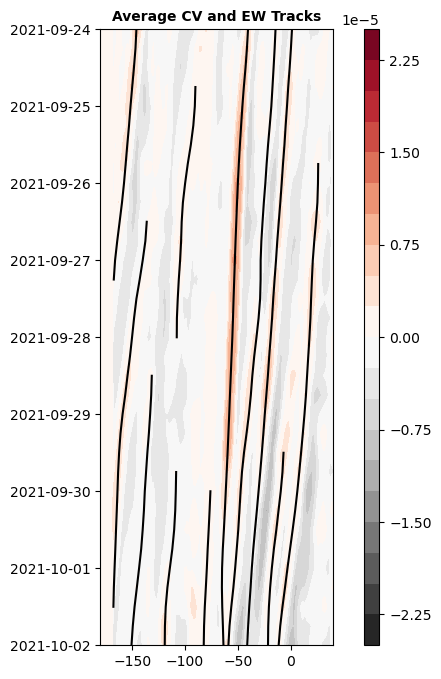

In [61]:
fig = plt.figure(figsize = (4, 8))

cv_conts = np.arange(-2.5e-5, 2.6e-5, 2.5e-6)

ax = fig.add_subplot(1,1,1)
cv_mean = cv_data_in.sel(latitude = slice(20, 5)).mean('latitude')
ax.plot(track_data_in.AEW_lon_smooth.T, track_data_in.time, color = 'k')
d1 = ax.contourf(cv_mean.longitude, cv_mean.time, cv_mean['curv_vort'],
                 levels = cv_conts, cmap = 'RdGy_r')
plt.colorbar(d1, orientation = 'vertical', aspect = 40, pad = 0.1)


### Settings for Plot
ax.invert_yaxis()
ax.set_xlim([-180, 40])
ax.set_title("Average CV and EW Tracks", fontsize = 10, fontweight = 'bold', loc = 'center')